# **Audio Classification with Transfer Learning - ADNE**

Jorge Gómez Berenguer - Github: jorgegomez94

Raúl Gómez Serrano - Github: raulgomez05

En esta práctica se va a realizar la clasificación de diferentes pistas de audio pertenecientes a 10 géneros de música. El dataset utilizado se puede obtener en el siguiente enlace:
https://www.kaggle.com/carlthome/gtzan-genre-collection

Se conecta con el Drive personal donde está subido el dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se importan las librerías necesarias

In [ ]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import keras

import warnings
warnings.filterwarnings('ignore')

Librerías pertenecientes al modelo preentrenado de pytorch

In [ ]:
!pip install torchaudio

In [ ]:
import torch
import torchvision
import torchaudio
import random
import librosa.display
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as T

## Extracción de Espectogramas para cada Audio

Se establece el color con el que se generarán los espectogramas

In [ ]:
cmap = plt.get_cmap('inferno')

Se generan los espectogramas

In [ ]:
plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'/content/drive/MyDrive/Colab Notebooks/archive/genres/{g}'):
        songname = f'/content/drive/MyDrive/Colab Notebooks/archive/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

<Figure size 720x720 with 0 Axes>

## Extracción de Features en base a los Espectogramas

Las features que se van a extraer son las siguientes:
*   **chroma_stft**: Compute a chromagram from a waveform or power spectrogram.
*   **chroma_cqt**: Constant-Q chromagram
*   **chroma_cens**: Computes the chroma variant “Chroma Energy Normalized” (CENS)
*   **melspectogram**: Compute a mel-scaled spectrogram.
*   **mfcc**: Mel-frequency cepstral coefficients (MFCCs)
*   **rmse**: Compute root-mean-square (RMS) value for each frame, either from the audio samples y or from a spectrogram S.
*   **spec_cent**: Compute the spectral centroid.
*   **spec_bw**: Compute p’th-order spectral bandwidth.
*   **spec_cont**: Compute spectral contrast
*   **spec_flat**: Compute spectral flatness
*   **spec_rolloff**: Compute roll-off frequency.
*   **poly_features**: Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram.
*   **tonnetz**: Computes the tonal centroid features (tonnetz)
*   **zero-crossing_rate**: Compute the zero-crossing rate of an audio time series.

In [ ]:
header = 'filename chroma_stft chroma_cqt chroma_cens melspectogram mfcc rmse spec_cent spec_bw spec_cont spec_flat spec_rolloff poly_features tonnetz zcr'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

## Se escriben los datos a un CSV

In [ ]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

for g in genres:
    for filename in os.listdir(f'/content/drive/MyDrive/Colab Notebooks/archive/genres/{g}'):

        songname = f'/content/drive/MyDrive/Colab Notebooks/archive/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)

        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
        chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)

        melspectogram = librosa.feature.melspectrogram(y=y, sr=sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)

        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spec_cont = librosa.feature.spectral_contrast(y=y, sr=sr)
        spec_flat = librosa.feature.spectral_flatness(y=y)
        spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

        poly_features = librosa.feature.poly_features(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(chroma_cqt)} {np.mean(chroma_cens)} {np.mean(melspectogram)} {np.mean(mfcc)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(spec_cont)} {np.mean(spec_flat)} {np.mean(spec_rolloff)} {np.mean(poly_features)} {np.mean(tonnetz)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

## Análisis de los Datos

In [ ]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,chroma_cqt,chroma_cens,melspectogram,mfcc,rmse,spec_cent,spec_bw,spec_cont,spec_flat,spec_rolloff,poly_features,tonnetz,zcr,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00001.au,0.340983,0.476364,0.260808,2.653045,-0.058071,0.095918,1529.835316,2038.617579,20.676334,0.002294,3548.820207,1.034521,0.029177,0.056044,-207.556793,124.006721,8.930560,35.874687,2.916037,21.523726,-8.554704,23.358671,-10.103617,11.903744,-5.560388,5.376803,-2.239120,4.216963,-6.012273,0.936110,-0.716537,0.293876,-0.287431,0.531573,blues
1,blues.00002.au,0.363603,0.443113,0.262626,7.256842,1.033480,0.175573,1552.481958,1747.165985,22.197265,0.002628,3040.514948,2.454359,0.024271,0.076301,-90.754387,140.459900,-29.109968,31.689013,-13.987036,25.754759,-13.649585,11.629271,-11.780589,9.706443,-13.123111,5.789265,-8.905224,-1.083720,-9.218359,2.455806,-7.726901,-1.815723,-3.433434,-2.226821,blues
2,blues.00000.au,0.349943,0.537810,0.272217,4.425312,1.935691,0.130225,1784.420446,2002.650192,20.530733,0.004499,3806.485316,1.751873,0.006478,0.083066,-113.596748,121.557297,-19.158825,42.351032,-6.376458,18.618876,-13.697912,15.344631,-12.285267,10.980492,-8.324325,8.810669,-3.667368,5.751691,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929,blues
3,blues.00004.au,0.308590,0.496904,0.259589,2.107707,-8.457871,0.091563,1835.494603,1748.362448,21.467739,0.003239,3580.945013,1.249837,-0.020858,0.101500,-160.266037,126.198799,-35.605450,22.153301,-32.489265,10.864513,-23.357929,0.503118,-11.805833,1.206805,-13.083821,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409332,-11.703781,blues
4,blues.00003.au,0.404779,0.317227,0.226360,6.214398,0.078956,0.141191,1070.119953,1596.333948,21.428764,0.000953,2185.028454,1.244653,0.026556,0.033309,-199.431152,150.099213,5.647593,26.871927,1.754462,14.238345,-4.830883,9.297966,-0.757742,8.149013,-3.196314,6.087677,-2.476421,-1.073890,-2.874778,0.780977,-3.316932,0.637982,-0.619690,-3.408233,blues


In [ ]:
data.shape

(1000, 36)

Eliminamos columnas inncesarias

In [ ]:
data = data.drop(['filename'],axis=1)

## Classification con Pytorch - Transfer Learning

Generamos un dataset customizado mediante la técnica de Data Augmentation

In [ ]:
batch_size = 8
image_size = 224
train_trms = T.Compose([T.Resize(image_size), T.RandomRotation(20),T.RandomHorizontalFlip(),T.ToTensor()])
val_trms = T.Compose([T.Resize(image_size),T.ToTensor()])
img_path = '/content/img_data'

In [ ]:
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

Se dividen de manera aleatoria los datos en el dataset de training (80%) y el de validación (20%)

In [ ]:
torch.manual_seed(100)
val_size = int(len(train_data)*0.2)
train_size = len(train_data) - val_size

from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(800, 200)

Aprovechando la ventaja que ofrece Pytorch de paralelizar la computación del algoritmo, se procede a cargar los datos con el objeto DataLoader.

Este permite dividir el dataset en un número de batches determinado (8 para nuestro caso) y poder así trabajar en paralelo con ellos

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Se realiza un plot en el que se pueden observar las imágenes de uno de los elementos del DataLoader de training

images.shape: torch.Size([8, 3, 224, 224])


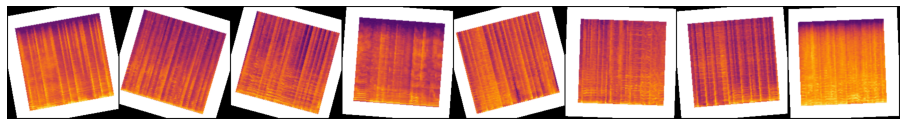

In [ ]:
for images, _ in train_dl:
  print('images.shape:', images.shape)
  plt.figure(figsize=(16, 8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute(1, 2, 0))
  break


Se define una función que muestre la precisión en las predicciones

In [ ]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

Se define la clase ImageClassificatorBase que contiene métodos que servirán de ayuda para el entrenamiento y validación

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

Se importa el modelo de la librería torchvision de Pytorch. 

Para anlizar el efecto que crea descongelar capas en el modelo, se procede a fitearlo con las capas completamente congeladas y posteriormente descongeladas

In [ ]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return self.network(xb)
    def freeze(self):
      for param in self.network.parameters():
        param.require_grad = False
      for param in self.network.fc.parameters():
        param.require_grad = True
    
    def unfreeze(self):
      for param in self.network.parameters():
        param.require_grad = True


Se definen una serie de cambios en la función que se utilizará para fitear el modelo. Entre ellos: 

- Scheduler para learning rate que optimice dicho hiperparámetro
- Weight decay: técnica de regularización para evitar que los pesos sean demasiado elevados
- Gradient clipping: servirá para limitar el valor de los gradientes a un rango menor y así evitar cambios indeseables en parámetros debido a valores en los gradientes muy elevados

In [ ]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Se puede analizar la arquitectura del modelo ResNet34

In [ ]:
model = (Net())
model

Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

Hiperparámetros que vamos a pasar a la función fit_one_cycle para que el modelo entrene


*   Número de épocas
*   Máximo learning rate que puede alcanzar el learning rate scheduler (sched)
*   Valor del gradient clipping
*   Weight decay
*   Como optimizador, se utilizará el Adam optimizer







In [ ]:
epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

### Model Freeze

Como se ha descrito previamente, en esta primera iteración el modelo se ajustará con todas sus capas congeladas

In [ ]:
model.freeze()

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 1.6980, val_score: 0.3846



Epoch [1], val_loss: 1.9441, val_score: 0.3269



Epoch [2], val_loss: 1.6546, val_score: 0.3942



Epoch [3], val_loss: 1.5848, val_score: 0.4327



Epoch [4], val_loss: 1.4842, val_score: 0.4423



Epoch [5], val_loss: 1.3357, val_score: 0.5385



Epoch [6], val_loss: 1.2228, val_score: 0.6058



Epoch [7], val_loss: 1.0750, val_score: 0.6154



Epoch [8], val_loss: 0.9896, val_score: 0.6538



Epoch [9], val_loss: 1.0286, val_score: 0.6538


In [ ]:
test_loader = DeviceDataLoader(DataLoader(train_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6136257648468018, 'val_score': 0.7962499856948853}

Plots de accuracy, losses y learning rate a lo largo de las épocas 

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_score'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

Accuracy

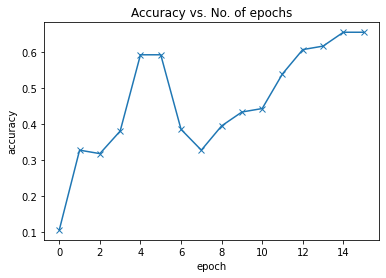

In [ ]:
plot_accuracies(history)

Validation losses

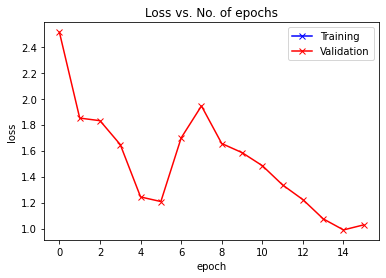

In [ ]:
plot_losses(history)

Learning rate

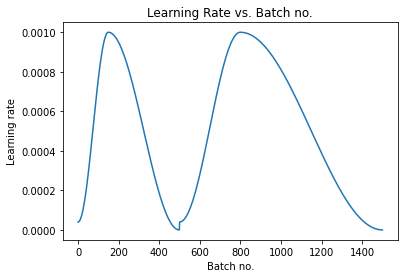

In [ ]:
plot_lrs(history)

### Model Unfreeze

Se procede a descongelar por completo el modelo, para entrenar todas sus capas

In [ ]:
model.unfreeze()

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 1.0863, val_score: 0.6346



Epoch [1], val_loss: 1.5852, val_score: 0.4038



Epoch [2], val_loss: 1.4125, val_score: 0.4808



Epoch [3], val_loss: 1.1997, val_score: 0.5865



Epoch [4], val_loss: 1.1945, val_score: 0.5913



Epoch [5], val_loss: 1.2004, val_score: 0.5769



Epoch [6], val_loss: 1.1383, val_score: 0.5913



Epoch [7], val_loss: 1.0799, val_score: 0.6442



Epoch [8], val_loss: 0.9449, val_score: 0.6779



Epoch [9], val_loss: 0.9128, val_score: 0.6875


In [ ]:
test_loader = DeviceDataLoader(DataLoader(train_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.4072801172733307, 'val_score': 0.8700000047683716}

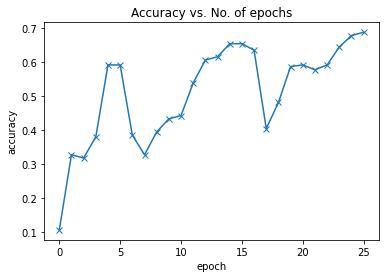

In [ ]:
plot_accuracies(history)

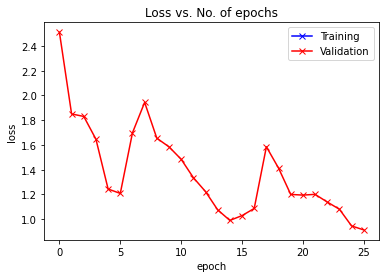

In [ ]:
plot_losses(history)

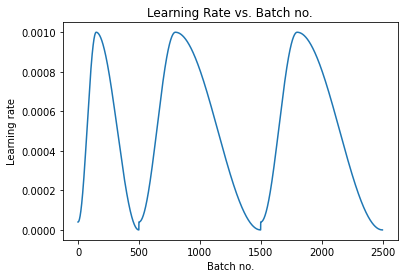

In [ ]:
plot_lrs(history)